In [17]:
import numpy as np
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from scipy import stats
from collections import defaultdict
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
from collections import Counter

# Example of Euclidean distance and DTW distance

In [57]:
s1 = np.array([0,0,1,2,1,0,1,0,0,2,1,0,0], dtype=float)
s2 = np.array([0,1,2,3,1,0,0,0,2,1,0,0,0], dtype=float)
t = np.linspace(0, len(s1), num=len(s1), endpoint=True)
print(len(t), len(s1))
f1 = interp1d(t, s1, kind='cubic')
f2 = interp1d(t, s2, kind='cubic')

t2 = np.linspace(0, len(s1), num=100, endpoint=True)
s1 = f1(t2)
s2 = f2(t2)

13 13


In [5]:
class DTWBase(object):
    def __init__(self, arr1, arr2):
        self.arr1 = arr1
        self.arr2 = arr2
        self.n = len(arr1)
        self.m = len(arr2)
        self.warping_matrix = None
    def set_matrix(self):
        self.warping_matrix = np.zeros((self.n+1, self.m+1)) - 1
        self.warping_matrix[:,0] = np.inf
        self.warping_matrix[0,:] = np.inf
        self.warping_matrix[0,0] = 0
    def cost(self, i, j):
        return (self.arr1[i] - self.arr2[j]) ** 2
    def compute(self):
        for i in range(1,self.n+1):
            for j in range(1, self.m+1):
                d = self.cost(i-1, j-1)
                self.warping_matrix[i,j] = d + min(self.warping_matrix[i-1,j],
                                                   self.warping_matrix[i,j-1], 
                                                   self.warping_matrix[i-1,j-1])
    def find_path(self):
        n,m = self.warping_matrix.shape
        i = n-1
        j = m-1
        path = []
        while i != 0 and j != 0:
            path.append((i-1, j-1))
            vals = [self.warping_matrix[i-1,j], 
                    self.warping_matrix[i,j-1], 
                    self.warping_matrix[i-1,j-1]]
            idx = np.argmin(vals)
            if vals[0] == vals[1] and vals[0] == vals[2]:
                i -= 1
                j -= 1
            else:
                if idx == 0:
                    i -= 1
                elif idx == 1:
                    j -= 1
                elif idx == 2:
                    i -= 1
                    j -= 1
        return path[::-1]
    
    def distance(self):
        return self.warping_matrix[self.n,self.m]
    
    def paths(self):
        return self.warping_matrix

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 1), (6, 2), (6, 3), (7, 4), (8, 5), (9, 6), (10, 7), (10, 8), (10, 9), (10, 10), (10, 11), (11, 12), (12, 12), (13, 13), (14, 14), (15, 14), (16, 14), (17, 14), (18, 14), (19, 14), (20, 14), (21, 14), (22, 15), (23, 16), (23, 17), (23, 18), (23, 19), (23, 20), (24, 21), (25, 22), (26, 23), (27, 24), (28, 25), (29, 26), (30, 27), (31, 28), (32, 29), (33, 30), (34, 31), (35, 32), (36, 33), (37, 34), (38, 34), (39, 35), (39, 36), (39, 37), (39, 38), (39, 39)]


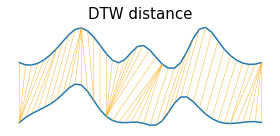

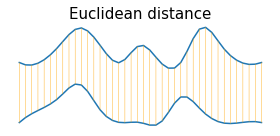

In [7]:
d1, paths1 = dtw.warping_paths(s1, s2)
path1 = dtw.warping_path(s1, s2)
x1, y1 = zip(*path1)

idtw = DTWBase(s1, s2)
idtw.set_matrix()
idtw.compute()
d2 = idtw.distance()
paths2 = idtw.paths()
path2 = idtw.find_path()
x2, y2 = zip(*path2)


fig, ax = dtwvis.plot_warping(s1, s2, path1)
ax[1].get_shared_y_axes().remove(ax[1])
ax[0].get_shared_y_axes().remove(ax[0])
ax[0].set_ylim([-0.5, 2.2])
# ax[1].set_ylim([-0.5, 3.5])
ax[0].axis("off")
ax[0].set_title("DTW distance", fontsize=15)
ax[1].axis("off")
fig.set_size_inches(4, 2, forward=True)
# _ = dtwvis.plot_warping(s1, s2, path2)
print(path1)
plt.tight_layout()
fig.savefig("dtw_example.png", dpi=300)

euclidean_path = [(i, i) for i in range(len(s1))]

fig, ax = dtwvis.plot_warping(s1, s2, euclidean_path)
ax[1].get_shared_y_axes().remove(ax[1])
ax[0].get_shared_y_axes().remove(ax[0])
ax[0].set_ylim([-0.5, 2.2])
# ax[1].set_ylim([-0.5, 3.5])
ax[0].axis("off")
ax[0].set_title("Euclidean distance", fontsize=15)
ax[1].axis("off")
fig.set_size_inches(4,2, forward=True)
plt.tight_layout()
fig.savefig("euclidean_example.png", dpi=300)

# Example of sliding window on regular time series and SAX generation

[0.29794816 0.85314493 1.4083417 ]
0.29794816027607507 0
0.853144928562434 1
1.408341696848793 2
-0.1078740298452142 0 7 0
0.22743753563237257 7 15 0
1.3170904064033635 15 23 2
1.8557984322582584 23 31 3
(-0.5050294060455849, 2.2113192631704526)
A
B
C
D


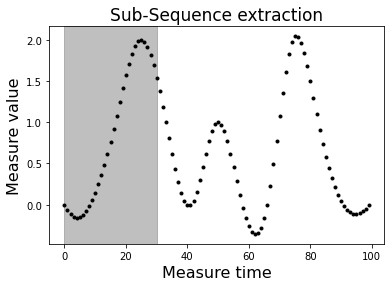

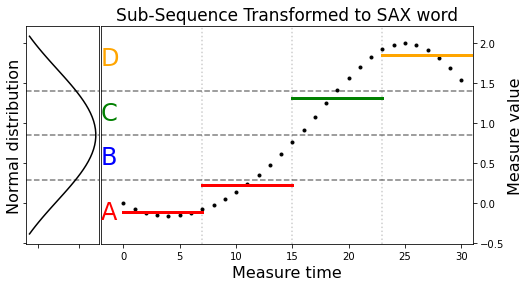

In [309]:
fig1 = plt.figure(figsize=(6, 4))
plt.plot(s1, ".k")
plt.title("Sub-Sequence extraction", fontsize=17)
plt.xlabel("Measure time", fontsize=16)
plt.ylabel("Measure value", fontsize=16)
cut_ini = 0
cut_end = 30
plt.axvspan(cut_ini, cut_end, alpha=0.5, color="gray")
plt.savefig("subseq_extraction_ex1.png", dpi=250)
s1_cut = s1[cut_ini:cut_end+1]

# left, width = 0.1, 0.65
# bottom, height = 0.1, 0.65
# spacing = 0.00


# rect_scatter = [left, bottom, width, height]
# rect_histy = [left - spacing - 0.14, bottom, left, height]

# fig = plt.figure(figsize=(8, 4))
# ax = fig.add_axes(rect_scatter)
# ax2 = fig.add_axes(rect_histy, sharey=ax)
# ax2.tick_params(axis="y", labelleft=False)
# ax2.tick_params(axis="x", labelbottom=False)

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(4, 6, figure=fig)
ax2 = fig.add_subplot(gs[:, :1])
ax = fig.add_subplot(gs[:, 1:], sharey=ax2)
ax2.tick_params(axis="y", labelleft=False)
ax2.tick_params(axis="x", labelbottom=False)
ax.set_xlim([-2, len(s1_cut)])
gs.update(wspace=0.025, hspace=0.05)

ax.plot(s1_cut, ".k")

mu = np.mean(s1_cut)
std = np.std(s1_cut)
# x = np.linspace(np.min(s1_cut), np.max(s1_cut), 30)
x = np.linspace(mu - 1.5*std, mu + 1.5*std, 50)
p = norm.pdf(x, mu, std)
alph_size = 4
alph_colors = ["r", "b", "g", "orange"]
bps = norm.ppf(np.linspace(0, 1, alph_size + 1)[1:-1], mu, std)
print(bps)

ax2.plot(p, x, "k")
# ax2.fill_between(p, bps[0], bps[1], color="r")
# ax2.fill_between(p, bps[0], bps[1])
for i, bp in enumerate(bps):
    print(bp, i)
    ax2.axhline(bp, color="k", alpha=0.5, linestyle="--")
    ax.axhline(bp, color="k", alpha=0.5, linestyle="--")
    
word_len = 4
limits = [0]
for i in range(1,word_len):
    limit = int((len(s1_cut)/word_len) * i)
    ax.axvline(limit, linestyle=":", color="k", alpha=0.2)
    limits.append(limit)
limits.append(len(s1_cut))
    
for i in range(len(limits)-1):
    ini = int(limits[i])
    end = int(limits[i+1])
    mean_val = np.mean(s1_cut[ini:end])
    idx_mean = np.digitize(mean_val, bps)
    print(mean_val, ini, end, idx_mean)
    seg_line = np.linspace(ini, end, 5)
    mean_val_line = [mean_val]*5
    ax.plot(seg_line, mean_val_line, color=alph_colors[idx_mean], linewidth=3)
    
ax2.set_ylabel("Normal distribution", fontsize=16)
ax.set_xlabel("Measure time", fontsize=16)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel("Measure value", fontsize=16)

alph_letters = ["A", "B", "C", "D"]
offset_c = 0
lims = ax.get_ylim()
print(lims)
for i in range(len(bps)+1):
    print(alph_letters[i])
    if i == 0:
        center = lims[0] + (bps[0]-lims[0])/2
    elif i == len(bps):
        center = bps[i-1] + (lims[1] - bps[i-1])/2    
    else:
        center = bps[i-1] + (bps[i] - bps[i-1])/2
    
    c = (- lims[0] + center) / (lims[1]-lims[0])
#     ax.axhline(center)
    plt.text(0, c, alph_letters[i], va="center", transform=ax.transAxes, fontsize=24, color=alph_colors[i])
    
# print(c1, c2)
# plt.text(0, c1, "A", ha='center', va='center', transform=ax.transAxes, fontsize=24, color="r")
# plt.text(0, c2, "B", ha='center', va='center', transform=ax.transAxes, fontsize=24, color="b")
# plt.text(0.57, 1.12, "C", ha='center', va='center', transform=ax.transAxes, fontsize=24, color="g")
# plt.text(0.57, 1.75, "D", ha='center', va='center', transform=ax.transAxes, fontsize=24, color="orange")
ax.set_title("Sub-Sequence Transformed to SAX word", fontsize=17)
# plt.tight_layout()
plt.savefig("subse_to_word_ex1.png", dpi=250)
# ax2.hist(p, orientation='horizontal', density=True)

[0.42172868 0.83000137 1.23827406]
0.42172868411229386 0
0.8300013700809373 1
1.2382740560495809 2
1.759375193829149 0 7 3
0.5633350679990521 7 15 1
0.29055409438430413 15 23 0
0.8229128520797705 23 31 1
(-0.18188634884712598, 2.104545798482658)
A
B
C
D


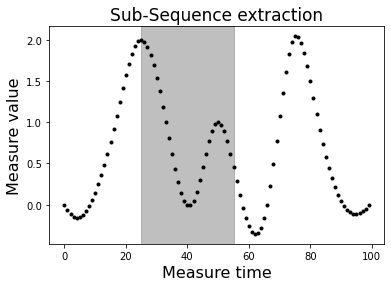

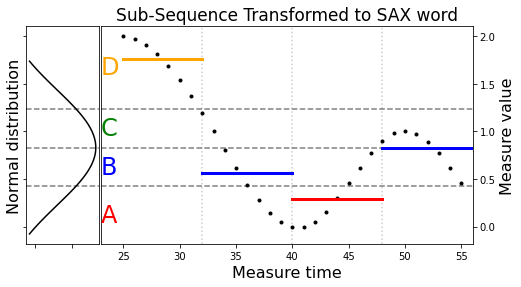

In [308]:
fig1 = plt.figure(figsize=(6, 4))
plt.plot(s1, ".k")
plt.title("Sub-Sequence extraction", fontsize=17)
plt.xlabel("Measure time", fontsize=16)
plt.ylabel("Measure value", fontsize=16)
cut_ini = 25
cut_end = 25+30
plt.axvspan(cut_ini, cut_end, alpha=0.5, color="gray")
plt.savefig("subseq_extraction_ex2.png", dpi=250)
s1_cut = s1[cut_ini:cut_end+1]

# left, width = 0.1, 0.65
# bottom, height = 0.1, 0.65
# spacing = 0.00


# rect_scatter = [left, bottom, width, height]
# rect_histy = [left - spacing - 0.14, bottom, left, height]

# fig = plt.figure(figsize=(8, 4))
# ax = fig.add_axes(rect_scatter)
# ax2 = fig.add_axes(rect_histy, sharey=ax)
# ax2.tick_params(axis="y", labelleft=False)
# ax2.tick_params(axis="x", labelbottom=False)

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(4, 6, figure=fig)
ax2 = fig.add_subplot(gs[:, :1])
ax = fig.add_subplot(gs[:, 1:], sharey=ax2)
ax2.tick_params(axis="y", labelleft=False)
ax2.tick_params(axis="x", labelbottom=False)
ax.set_xlim([-2, len(s1_cut)])
gs.update(wspace=0.025, hspace=0.05)

ax.plot(s1_cut, ".k")

mu = np.mean(s1_cut)
std = np.std(s1_cut)
# x = np.linspace(np.min(s1_cut), np.max(s1_cut), 30)
x = np.linspace(mu - 1.5*std, mu + 1.5*std, 50)
p = norm.pdf(x, mu, std)
alph_size = 4
alph_colors = ["r", "b", "g", "orange"]
bps = norm.ppf(np.linspace(0, 1, alph_size + 1)[1:-1], mu, std)
print(bps)

ax2.plot(p, x, "k")
# ax2.fill_between(p, bps[0], bps[1], color="r")
# ax2.fill_between(p, bps[0], bps[1])
for i, bp in enumerate(bps):
    print(bp, i)
    ax2.axhline(bp, color="k", alpha=0.5, linestyle="--")
    ax.axhline(bp, color="k", alpha=0.5, linestyle="--")
    
word_len = 4
limits = [0]
for i in range(1,word_len):
    limit = int((len(s1_cut)/word_len) * i)
    ax.axvline(limit, linestyle=":", color="k", alpha=0.2)
    limits.append(limit)
limits.append(len(s1_cut))
    
for i in range(len(limits)-1):
    ini = int(limits[i])
    end = int(limits[i+1])
    mean_val = np.mean(s1_cut[ini:end])
    idx_mean = np.digitize(mean_val, bps)
    print(mean_val, ini, end, idx_mean)
    seg_line = np.linspace(ini, end, 5)
    mean_val_line = [mean_val]*5
    ax.plot(seg_line, mean_val_line, color=alph_colors[idx_mean], linewidth=3)
    
ax2.set_ylabel("Normal distribution", fontsize=16)
ax.set_xlabel("Measure time", fontsize=16)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel("Measure value", fontsize=16)

alph_letters = ["A", "B", "C", "D"]
offset_c = 0
lims = ax.get_ylim()
print(lims)
for i in range(len(bps)+1):
    print(alph_letters[i])
    if i == 0:
        center = lims[0] + (bps[0]-lims[0])/2
    elif i == len(bps):
        center = bps[i-1] + (lims[1] - bps[i-1])/2    
    else:
        center = bps[i-1] + (bps[i] - bps[i-1])/2
    
    c = (- lims[0] + center) / (lims[1]-lims[0])
#     ax.axhline(center)
    plt.text(0, c, alph_letters[i], va="center", transform=ax.transAxes, fontsize=24, color=alph_colors[i])

new_xticks = np.arange(6) * len(s1_cut)//6
new_xticks = np.append(new_xticks, len(s1_cut)-1)
ax.set_xticks(new_xticks)
ax.set_xticklabels(new_xticks + cut_ini, minor=False)

ax.set_title("Sub-Sequence Transformed to SAX word", fontsize=17)
# plt.tight_layout()
plt.savefig("subse_to_word_ex2.png", dpi=250)
# ax2.hist(p, orientation='horizontal', density=True)

# Numerosity reduction example

C:\ProgramData\Miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


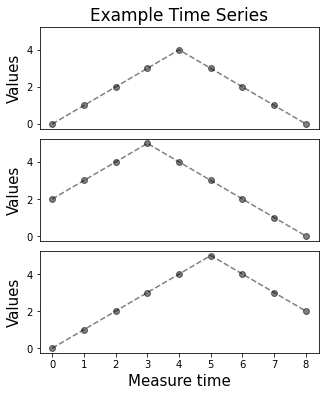

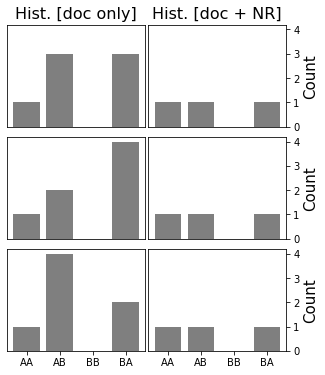

In [108]:
y1 = [0, 1, 2, 3, 4, 5, 4, 3, 2]
y2 = [2, 3, 4, 5, 4, 3, 2, 1, 0]
y3 = [0, 1, 2, 3, 4, 3, 2, 1, 0]

# fig, ax = plt.subplots(3, 1, figsize=(5, 6), sharex=True)
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(3, 1, figure=fig)
ax0 = fig.add_subplot(gs[0, :])
ax0.tick_params(axis="x", labelbottom=False, bottom=False)
ax1 = fig.add_subplot(gs[1, :], sharex=ax0, sharey=ax0)
ax1.tick_params(axis="x", labelbottom=False, bottom=False)
ax2 = fig.add_subplot(gs[2, :], sharex=ax0, sharey=ax1)
ax = [ax0, ax1, ax2]

gs.update(hspace=0.1)

ax[0].plot(y3, "ko--", alpha=0.5)
# ax[0].set_ylim([-2, 6])
ax[1].plot(y2, "ko--", alpha=0.5)
# ax[1].set_ylim([-2, 6])
ax[2].plot(y1, "ko--", alpha=0.5)
# ax[2].set_ylim([-2, 6])
ax[2].set_xlabel("Measure time", fontsize=15)
ax[0].set_title("Example Time Series", fontsize=17)
ax[0].set_ylabel("Values", fontsize=15)
ax[1].set_ylabel("Values", fontsize=15)
ax[2].set_ylabel("Values", fontsize=15)
plt.tight_layout()
plt.savefig("numerosity_reduction_ex1_pt1.png", dpi=250)


w3 = ["AB", "AB", "AB", "AA", "BA", "BA", "BA"]
w2 = ["AB", "AB", "AA", "BA", "BA", "BA", "BA"]
w1 = ["AB", "AB", "AB", "AB", "AA", "BA", "BA"]

w3c = ["AB", "AA", "BA"]
w2c = ["AB", "AA", "BA"]
w1c = ["AB", "AA", "BA"]

counts1 = Counter(w1)
counts2 = Counter(w2)
counts3 = Counter(w3)

counts1c = Counter(w1c)
counts2c = Counter(w2c)
counts3c = Counter(w3c)

labels = ["AA", "AB", "BB", "BA"]
values1 = []
values2 = []
values3 = []
values1c = []
values2c = []
values3c = []
for lbl in labels:
    values1.append(counts1.get(lbl, 0))
    values2.append(counts2.get(lbl, 0))
    values3.append(counts3.get(lbl, 0))
    
    values1c.append(counts1c.get(lbl, 0))
    values2c.append(counts2c.get(lbl, 0))
    values3c.append(counts3c.get(lbl, 0))

# fig, ax = plt.subplots(3, 2, figsize=(5, 6), sharex=True, sharey=True)
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(3, 2, figure=fig)
ax01 = fig.add_subplot(gs[0, :1])
ax02 = fig.add_subplot(gs[0, 1:], sharey=ax01)
ax01.tick_params(axis="x", labelbottom=False, bottom=False)
ax02.tick_params(axis="x", labelbottom=False, bottom=False)
ax02.tick_params(axis="y", labelleft=False, left=False, right=True, labelright=True)
ax01.tick_params(axis="y", left=False, labelleft=False)

ax11 = fig.add_subplot(gs[1, :1], sharey=ax01)
ax12 = fig.add_subplot(gs[1, 1:], sharey=ax11)
ax11.tick_params(axis="x", labelbottom=False, bottom=False)
ax12.tick_params(axis="x", labelbottom=False, bottom=False)
ax12.tick_params(axis="y", labelleft=False, left=False, right=True, labelright=True)
ax11.tick_params(axis="y", left=False, labelleft=False)

ax21 = fig.add_subplot(gs[2, :1], sharey=ax01)
ax22 = fig.add_subplot(gs[2, 1:], sharey=ax21)
# ax21.tick_params(axis="x", labelbottom=False, bottom=False)
# ax22.tick_params(axis="x", labelbottom=False, bottom=False)
ax22.tick_params(axis="y", labelleft=False, left=False, right=True, labelright=True)
ax21.tick_params(axis="y", left=False, labelleft=False)

gs.update(hspace=0.1, wspace=0.025)

ax01.bar(labels, values3, color="k", alpha=0.5)
ax02.bar(labels, values3c, color="k", alpha=0.5)
ax02.yaxis.set_label_position("right")

ax11.bar(labels, values2, color="k", alpha=0.5)
ax12.bar(labels, values2c, color="k", alpha=0.5)
ax12.yaxis.set_label_position("right")

ax21.bar(labels, values1, color="k", alpha=0.5)
ax22.bar(labels, values1c, color="k", alpha=0.5)
ax22.yaxis.set_label_position("right")

ax01.set_title("Hist. [doc only]", fontsize=16)
ax02.set_title("Hist. [doc + NR]", fontsize=16)
ax02.set_ylabel("Count", fontsize=15)
ax12.set_ylabel("Count", fontsize=15)
ax22.set_ylabel("Count", fontsize=15)
plt.tight_layout()
plt.savefig("numerosity_reduction_ex1_pt2.png", dpi=250)